[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/naserahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


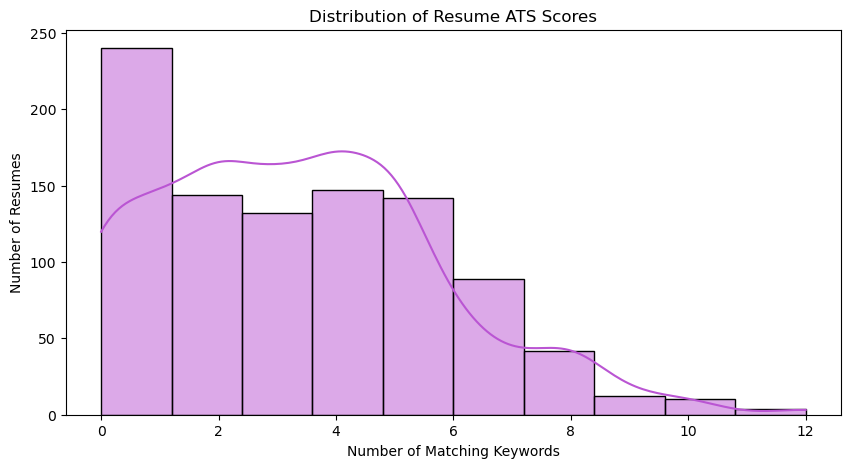

,Category,ATS_Score,Matched_Keywords,Missing_Keywords,Format_Feedback,Keyword_Recommendation
37,Data Science,12,"[like, data, communication, using, solving, sq...","[seeking, analyst, visualization, cleaning, pr...","[No bullet points detected, Resume might be to...",Great job! Your resume closely matches the job...
27,Data Science,12,"[like, data, communication, using, solving, sq...","[seeking, analyst, visualization, cleaning, pr...","[No bullet points detected, Resume might be to...",Great job! Your resume closely matches the job...
17,Data Science,12,"[like, data, communication, using, solving, sq...","[seeking, analyst, visualization, cleaning, pr...","[No bullet points detected, Resume might be to...",Great job! Your resume closely matches the job...
7,Data Science,12,"[like, data, communication, using, solving, sq...","[seeking, analyst, visualization, cleaning, pr...","[No bullet points detected, Resume might be to...",Great job! Your resume closely matches the job...
16,Data Science,10,"[data, visualization, using, cleaning, tools, ...","[like, seeking, analyst, communication, solvin...",[No bullet points detected],Great job! Your resume closely matches the job...
427,Business Analyst,10,"[like, data, analyst, communication, using, so...","[seeking, visualization, cleaning, mindset, in...","[No bullet points detected, Resume might be to...",Great job! Your resume closely matches the job...
26,Data Science,10,"[data, visualization, using, cleaning, tools, ...","[like, seeking, analyst, communication, solvin...",[No bullet points detected],Great job! Your resume closely matches the job...
423,Business Analyst,10,"[like, data, analyst, communication, using, so...","[seeking, visualization, cleaning, mindset, in...","[No bullet points detected, Resume might be to...",Great job! Your resume closely matches the job...
405,Business Analyst,10,"[like, data, analyst, communication, using, so...","[seeking, visualization, cleaning, mindset, in...","[No bullet points detected, Resume might be to...",Great job! Your resume closely matches the job...
419,Business Analyst,10,"[like, data, analyst, communication, using, so...","[seeking, visualization, cleaning, mindset, in...","[No bullet points detected, Resume might be to...",Great job! Your resume closely matches the job...


In [47]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv("/Users/naserahmed/Documents/ats-resume-analysis/data/resumes.csv")
df = df[['Resume', 'Category']]
df.dropna(inplace=True)

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

df['cleaned_resume'] = df['Resume'].apply(clean_text)

with open('/Users/naserahmed/Documents/ats-resume-analysis/data/job_description.txt', 'r') as f:
    jd = f.read()

jd_clean = clean_text(jd)
jd_keywords = set(jd_clean.split())

def score_resume(text, jd_keywords):
    resume_words = set(text.split())
    matched = resume_words.intersection(jd_keywords)
    missing = jd_keywords - resume_words
    return len(matched), list(matched), list(missing)

df[['ATS_Score', 'Matched_Keywords', 'Missing_Keywords']] = df['cleaned_resume'].apply(
    lambda x: pd.Series(score_resume(x, jd_keywords))
)

def check_format(text):
    feedback = []
    if len(re.findall(r'\n\s*[-•*]', text)) == 0:
        feedback.append("No bullet points detected")
    if "experience" not in text.lower():
        feedback.append("No 'Experience' section found")
    if len(text) > 3000:
        feedback.append("Resume might be too long (over 2 pages)")
    if not feedback:
        feedback.append("Resume format looks okay!")
    return feedback

df['Format_Feedback'] = df['Resume'].apply(check_format)

def recommend_keywords(row):
    missing = [kw.lower() for kw in row['Missing_Keywords']]
    score = row['ATS_Score']
    
    if score >= 8:
        return "Great job! Your resume closely matches the job description."
    elif 5 <= score < 8:
        suggestions = ', '.join(missing[:3])
        return f"You’re almost there. Consider adding: {suggestions}"
    elif 1 <= score < 5:
        suggestions = ', '.join(missing[:5])
        return f"Resume is under-matching. Try including these key terms:\n• {suggestions}"
    else:
        return "No strong matches. Consider revisiting your resume's keywords completely."

df['Keyword_Recommendation'] = df.apply(recommend_keywords, axis=1)

plt.figure(figsize=(10,5))
sns.histplot(df['ATS_Score'], bins=10, kde=True, color='mediumorchid')
plt.title("Distribution of Resume ATS Scores")
plt.xlabel("Number of Matching Keywords")
plt.ylabel("Number of Resumes")
plt.show()

df[['Category', 'ATS_Score', 'Matched_Keywords', 'Missing_Keywords', 'Format_Feedback', 'Keyword_Recommendation']].sort_values(by='ATS_Score', ascending=False).head(10)